In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load the training data
train_data = pd.read_csv('/kaggle/input/playground-series-s3e13/train.csv')

# Load the test data
test_data = pd.read_csv('/kaggle/input/playground-series-s3e13/test.csv')

# View the first few rows of the training data
print(train_data.sample(5))

      id  sudden_fever  headache  mouth_bleed  nose_bleed  muscle_pain  \
219  219           0.0       0.0          0.0         0.0          0.0   
430  430           1.0       1.0          1.0         0.0          0.0   
671  671           1.0       1.0          1.0         1.0          0.0   
357  357           0.0       0.0          0.0         1.0          0.0   
77    77           0.0       0.0          1.0         0.0          1.0   

     joint_pain  vomiting  rash  diarrhea  ...  breathing_restriction  \
219         1.0       0.0   0.0       1.0  ...                    0.0   
430         1.0       1.0   1.0       1.0  ...                    0.0   
671         0.0       1.0   1.0       1.0  ...                    0.0   
357         0.0       0.0   0.0       0.0  ...                    0.0   
77          0.0       0.0   0.0       0.0  ...                    0.0   

     toe_inflammation  finger_inflammation  lips_irritation  itchiness  \
219               0.0                  0.0

# Quick EDA

Before training the model, let's conduct some basic exploratory data analysis (EDA) to get an overall understanding of our data and determine if feature engineering is necessary.

For a more thorough, although incomplete, EDA of the original dataset (not the one used in the competition), please refer to my notebook: https://www.kaggle.com/code/irda22/eda-vector-borne-disease-dataset

Number of missing values in each column:
id                0
sudden_fever      0
headache          0
mouth_bleed       0
nose_bleed        0
                 ..
ulcers            0
toenail_loss      0
speech_problem    0
bullseye_rash     0
prognosis         0
Length: 66, dtype: int64
Number of duplicate rows:
0
Distribution of the target variable:
West_Nile_fever          85
Japanese_encephalitis    81
Tungiasis                70
Rift_Valley_fever        70
Chikungunya              66
Dengue                   63
Yellow_Fever             61
Zika                     58
Plague                   53
Lyme_disease             52
Malaria                  48
Name: prognosis, dtype: int64


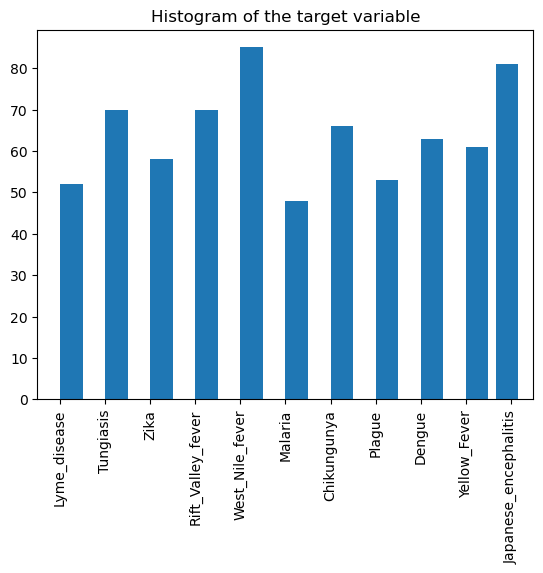

In [3]:
# Check for missing values
print("Number of missing values in each column:")
print(train_data.isnull().sum())

# Check for duplicates
print("Number of duplicate rows:")
print(train_data.duplicated().sum())

# Examine the target variable
print("Distribution of the target variable:")
print(train_data['prognosis'].value_counts())

# Histogram of the target variable
plt.hist(train_data['prognosis'], bins=30, width=0.5)
plt.title("Histogram of the target variable")
plt.xticks(rotation=90)
plt.show()

After our initial overview, we found that the data does not contain any null values. Therefore, we do not need to perform any further data manipulation for this purpose. However, we need to consider the uneven distribution of the target variable.

Before continuing, we will add a new feature to our dataset, which consists of the number of symptoms present in each sample. I believe this new feature will be helpful for our model.

In [4]:
train_data['symptom_sum'] = train_data.iloc[:, 1:-1].sum(axis=1)

In this step, we examine the new feature's distribution to ensure that there is enough variability and observe its behavior. Next, we will analyze the feature's significance in distinguishing the disease for each sample and the importance of other features in the subsequent step.

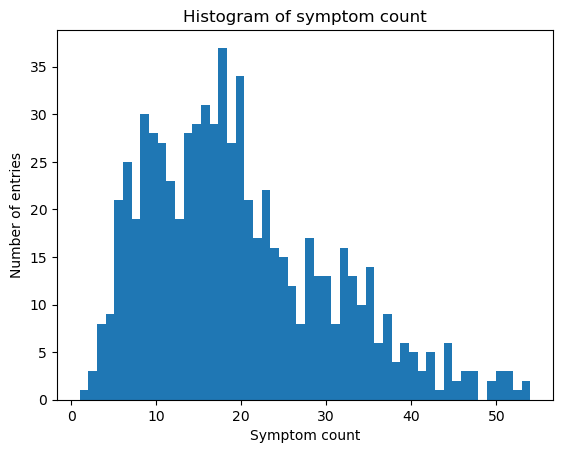

In [5]:
plt.hist(train_data['symptom_sum'], bins=len(np.unique(train_data['symptom_sum'])))
plt.title('Histogram of symptom count')
plt.xlabel('Symptom count')
plt.ylabel('Number of entries')
plt.show()

Although we are missing a lot of basic EDA techniques, such as outlier detection, it seems like the data already has a good structure. Although this approach may not be very scientific or professional, we will leave the data as it is for now.

# Data preprocessing

In [6]:
X = train_data.drop(['id', 'prognosis'], axis=1).reset_index(drop = True)
y = train_data['prognosis'].reset_index(drop = True) 
le = LabelEncoder()
y = le.fit_transform(y)
y = np.array(y)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Feature selection

One way to determine the most useful and important features in a dataset is by conducting a chi-squared test on the features (symptoms + symptom count) with respect to the prognosis column.

The chi-square test produces a test statistic and a p-value. The test statistic measures the difference between the observed frequencies of symptoms and the expected frequencies if there was no association between symptoms and diseases. The p-value indicates the strength of evidence against the null hypothesis of no association. If the p-value is very low (typically less than 0.05), we can reject the null hypothesis and conclude that there is strong evidence that the symptom is associated with the disease.

These test results can be useful for feature selection, as they can help identify the most relevant features.

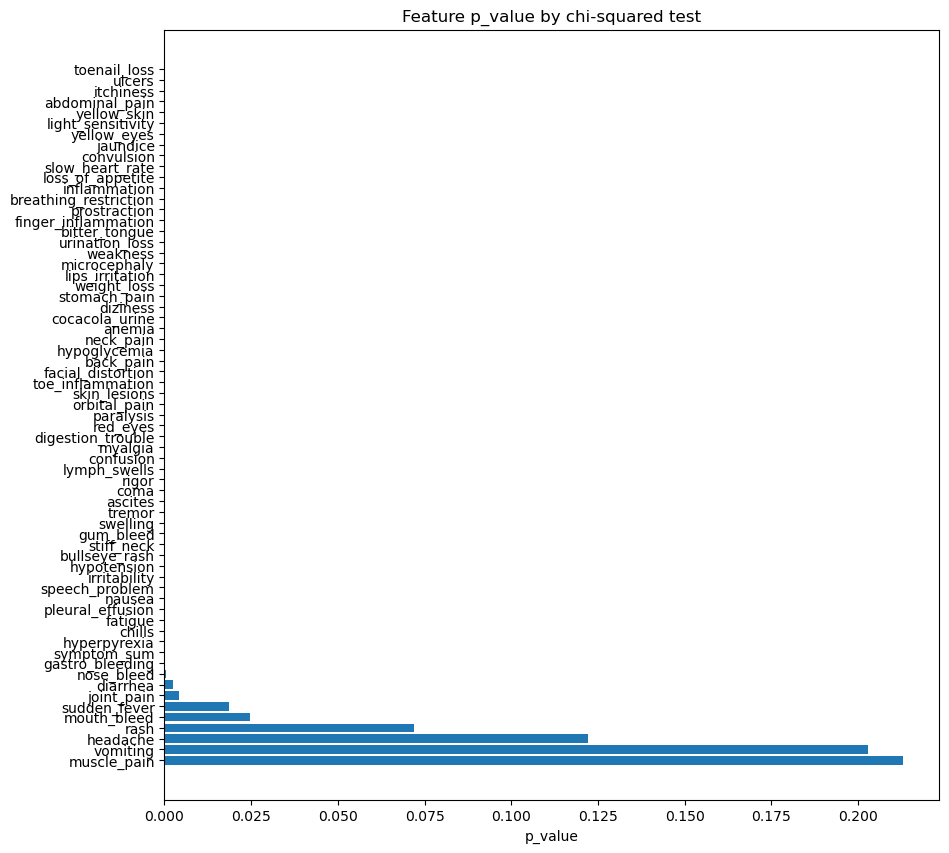

In [7]:
scores, p_values = chi2(X_scaled, y)
feature_scores = {feature: score for feature, score in zip(X.columns, p_values)}
sorted_scores = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

# Plot p-values
fig, ax = plt.subplots(figsize=(10,10))
ax.barh(range(len(sorted_scores)), [score[1] for score in sorted_scores])
ax.set_yticks(range(len(sorted_scores)))
ax.set_yticklabels([score[0] for score in sorted_scores])
ax.set_xlabel('p_value')
ax.set_title('Feature p_value by chi-squared test')
plt.show()

After training the model using all features, features with a p-value below 0.05, and features with a p-value below 0.01, we conclude that feature selection is not necessary and in fact, it makes the model perform worse (at least when using the chi-squared p-value criteria).

To test the notebook using different p-value thresholds, you can uncomment the code below.

In [8]:
'''X = train_data.drop(['id', 'prognosis'], axis=1).reset_index(drop = True)
print(len(X.columns))
significant_features = [score[0] for score in sorted_scores if score[1] < 0.05]
X_significant = X[significant_features]
print(len(X_significant.columns))
X_scaled = scaler.fit_transform(X_significant)'''

"X = train_data.drop(['id', 'prognosis'], axis=1).reset_index(drop = True)\nprint(len(X.columns))\nsignificant_features = [score[0] for score in sorted_scores if score[1] < 0.05]\nX_significant = X[significant_features]\nprint(len(X_significant.columns))\nX_scaled = scaler.fit_transform(X_significant)"

# Model

Before defining the model, we will first define the MPA@3 scorer function for evaluating the models. We will then modify the SVC predict function to predict the three most probable classes and a value related to their probabilities.

Regarding the model selection, I have conducted experiments and found that among XGBoost, KNN, and SVC, the latter provides the best results. To determine this, I conducted a grid search and made predictions with the top five SVC models from the search. The probability of each prediction and each model is summed up, with the model's performance weighted amongst the other four (where a model prediction probabilities contribute more to the sum than worse models and less than better models). I then use this sum to make a final prediction.


In [9]:
def map3_score(estimator, X_train, y_true):
    """
    Computes the mean Average Precision (MAP) at 3 score between the true labels and the predicted labels.
    Assumes that there is only one true label per sample.
    Args:
        y_true (array-like): True labels array, shape (n_samples,)
        y_pred (array-like): Predicted probabilities matrix, shape (n_samples, n_classes)
    Returns:
        float: MAP@3 score
    """

    score = 0.
    y_pred_top3 = estimator.predict(X_train)[0]
    
    # loop over each example and calculate its AP@3 score
    for i in range(len(y_true)):
        true_label = y_true[i]
        pred_labels = y_pred_top3[i]
        
        # calculate the AP@3 score for this example
        ap = 0.
        for j in range(3):
            if pred_labels[j] == true_label:
                ap = 1. / (j+1)
                break
        
        score += ap
        
    map3 = score / len(y_true)
    
    return map3

# creation of the scorer used durng grid search
map3_scorer = make_scorer(map3_score, greater_is_better=True)

In [10]:
class SVCTop3Classifier(SVC):
    def predict(self, X, top_n=3):
        proba = self.decision_function(X)
        top_n_idx = np.argsort(proba, axis=1)[:, -top_n:]
        top_n_proba = np.array([proba[i][top_n_idx[i]] for i in range(len(X))])
        return top_n_idx, top_n_proba
    

In [11]:
# take into account the class weight to give more attention to the underrepresented classes
class_weights = compute_sample_weight('balanced', y = y)

svm_classifier = SVCTop3Classifier()

# parameter grid defined with parameters that can impact the model's performance.
param_grid = {'C': [0.1, 1, 10],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': ['scale', 'auto'],
              'max_iter': [-1],
             }
# define grid-search with cross-validation
grid_search = GridSearchCV(svm_classifier, param_grid, scoring=map3_score, cv=5, verbose=3)
grid_search.fit(X_scaled, y, sample_weight=class_weights)

print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END C=0.1, gamma=scale, kernel=linear, max_iter=-1;, score=0.330 total time=   0.0s
[CV 2/5] END C=0.1, gamma=scale, kernel=linear, max_iter=-1;, score=0.335 total time=   0.0s
[CV 3/5] END C=0.1, gamma=scale, kernel=linear, max_iter=-1;, score=0.335 total time=   0.0s
[CV 4/5] END C=0.1, gamma=scale, kernel=linear, max_iter=-1;, score=0.285 total time=   0.0s
[CV 5/5] END C=0.1, gamma=scale, kernel=linear, max_iter=-1;, score=0.333 total time=   0.0s
[CV 1/5] END C=0.1, gamma=scale, kernel=poly, max_iter=-1;, score=0.242 total time=   0.0s
[CV 2/5] END C=0.1, gamma=scale, kernel=poly, max_iter=-1;, score=0.239 total time=   0.0s
[CV 3/5] END C=0.1, gamma=scale, kernel=poly, max_iter=-1;, score=0.316 total time=   0.0s
[CV 4/5] END C=0.1, gamma=scale, kernel=poly, max_iter=-1;, score=0.273 total time=   0.0s
[CV 5/5] END C=0.1, gamma=scale, kernel=poly, max_iter=-1;, score=0.241 total time=   0.0s
[CV 1/5] END C=0.1

In [12]:
# get the top 10 parameter combinations
results_df = pd.DataFrame(grid_search.cv_results_)
for i,row in results_df.sort_values(by=['rank_test_score']).head(10).iterrows():
    print(row['mean_test_score'],row['std_test_score'], row['params'])

0.340816768221623 0.025372548416580615 {'C': 1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1}
0.33423733892718016 0.01935640389718151 {'C': 1, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1}
0.3313771517996871 0.026588315976548697 {'C': 1, 'gamma': 'auto', 'kernel': 'sigmoid', 'max_iter': -1}
0.32340758498984457 0.019345633599513204 {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1}
0.32340758498984457 0.019345633599513204 {'C': 0.1, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': -1}
0.322463623347651 0.020845798486749983 {'C': 10, 'gamma': 'auto', 'kernel': 'sigmoid', 'max_iter': -1}
0.31797689208537283 0.020687066373336626 {'C': 10, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1}
0.31207671561282596 0.01906590025281712 {'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1}
0.29593114241001567 0.025932299337781135 {'C': 10, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': -1}
0.29593114241001567 0.025932299337781135 {'C': 10, 'gamma': 'scale', 'kernel': 

# Predictions

In [13]:
# Preprocessing test data
test_data['symptom_sum'] = test_data.iloc[:, 1:-1].sum(axis=1)
X_test = test_data.drop('id', axis=1)
'''X_test = X_test[significant_features]'''
X_test = scaler.transform(X_test)

# get top 10 parameter combinations
results_df = pd.DataFrame(grid_search.cv_results_)
top_5_params = results_df.sort_values(by=['rank_test_score']).head(5)['params']
top_5_scores = results_df.sort_values(by=['rank_test_score']).head(5)['mean_test_score']

# make predictions for top 3 classes for each of the top 10 models
top_3_preds = []
top_3_preds_proba = []
for params in top_5_params:
    clf = SVCTop3Classifier(**params)
    clf.fit(X_scaled, y, sample_weight=class_weights)
    preds, probs = clf.predict(X_test)
    top_3_preds.append([pr[::-1] for pr in preds])
    top_3_preds_proba.append([pr[::-1] for pr in probs])

In [14]:
predictions = np.zeros((X_test.shape[0], len(np.unique(y))))

for mod_idx, mod in enumerate(top_3_preds):
    mod_proba = top_3_preds_proba[mod_idx]
    for i in range(X_test.shape[0]):
        for k in range(len(mod[i])):
            class_idx = mod[i][k]
            predictions[i, class_idx] +=  mod_proba[i][k] * ((5-mod_idx)*0.2) #Model weight


final_predictions = np.argpartition(-predictions, 3)[:, :3]

The weights given to each model probability prediction follow this formula: weight = 0.2 * (5 - rank). For example, the second-best model's predictions will be multiplied by 0.8, while the fourth-best model's probabilities will be multiplied by 0.4. This way, the better models are taken into account more.

In [15]:
# create an empty dataframe for the submission file
submission_df = pd.DataFrame(columns=['id', 'prognosis'])
ids = test_data['id']
# Inverse transform the predicted class indices to get the actual class labels
predicted_labels = [le.inverse_transform(pred) for pred in final_predictions]

# Create a list of strings with the predicted class labels for each sample
predicted_labels_str = [f"{label[0]} {label[1]} {label[2]}" for label in predicted_labels]

# Write the submission file
with open("submission.csv", "w") as f:
    f.write("id,prognosis\n")
    for i in range(len(ids)):
        f.write(f"{ids[i]},{predicted_labels_str[i]}\n")

# Conclusion

Appart from trying with different models, I performed various experiments combining different techniques. I tried different feature selections, making the final predictions with just the top 5 model prediction counts instead of their probabilities, or with the probabilities without weights among others. However, the best performing combination was the one shown in the notebook. There are many more advanced techniques that can be applied such as boosting, stacking, or bagging, but this model gave an MPA@3 of 0.39845, which was enough to be in the top third of the public leaderboard.
